<a href="https://colab.research.google.com/github/khanh22mse23057/python4engineer-assignments/blob/main/Assignments1_M5_Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tìm hiểu về EDA + Time Series Analysis + TimeSeries Forecasting SARIMAX & Prophet

##  *Lời mở đầu*

M-competitions là cuộc thi được tổ chức bởi Spyros Makridakis nhằm đánh giá và so sánh độ chính xác của các phương pháp dự báo chuỗi thời gian khác nhau. Cuộc thi lần đầu tiên vào năm 1982 và đã trải qua 6 lần thi tính đến năm 2022.

Trong bài viết này, xin được đề cập về cuộc thi lần thứ 5 có tên M5-Forecasting diễn ra trong 4 tháng từ tháng 3 đến tháng 6 2020. Tệp dữ liệu được cung cấp bởi Walmart, được trích xuất từ dữ liệu lịch sử bán hàng bao gồm các hạng mục mặt hàng, bộ phận, danh mục sản phẩm và chi tiết cấp cửa hàng trên các cửa hàng ở 3 bang(California, Texas và Wisconsin), trải dài khoảng 30.000 sản phẩm khác nhau với lịch sử 1900 ngày.

Mục tiêu của cuộc thi M5 là dự báo trước cho doanh số bán hàng hàng ngày với chuỗi thời gian 28 ngày.

Một trong những đặc thù của cuộc thi này là chỉ số đánh để tìm ra độ chính xác của dự đoán cho dự báo, 
thông thường phương pháp Sai số bình phương trung bình(RMSE) với dữ liệu chuỗi thời gian để tìm ra độ chính xác trong bài toán này.
Vì vậy, sẽ có 3 đặc điểm chính được đề cập trong M5 để áp dụng:
1. Chuỗi thời gian phân cấu có cấu trúc 
2. Bán hàng không liên tục (mức độ bán hàng thấp với nhiều ngày không bán hàng)
3. Chỉ số đánh giá WRMSSE (sai số bình phương trung bình có trọng số gốc)

`Tham khảo: ` 
[M5-Forecasting|Kaggle](https://en.wikipedia.org/wiki/Makridakis_Competitions)      
[M5-Forecasting|Sciencedirect](https://www.sciencedirect.com/science/article/pii/S0169207021001874)



### **Cài đặt môi trường**
Để truy xuất được dữ liệu từ Kaggle cũng như chạy được các đoạn mã ví dụ cần phải cài đặt một số packages

In [1]:
# Một số functions trong bài không work với latest version, nên cài đặt packages version chỉ định như sau
!pip install opendatasets
!pip install pandas==1.2.0
!pip install pystan==3.0.0
# !pip install fbprophet 
!pip install scipy==1.2.1
!pip install kaggle
!pip install unzip

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/



### Import tệp dữ liệu training từ Kaggle
Để truy cập được tệp data từ Kaggle, cần phải tạo key và cấu hình môi trường

Ví dụ file secret key được tạo từ Kaggle và được lấy về từ github. Cách tạo key : https://prnt.sc/UCwb6zgoPzYT
* Lưu ý: Kaggle yêu cầu xác thực tài khoản bằng số điện thoại để cấp cấp quyền truy cập dữ liệu.

In [2]:
import os
#Cấu hình secret key để xác thực truy cập đến Kaggle trên môi trường
os.environ['KAGGLE_USERNAME'] = 'khanhphamnguyenphu'
os.environ['KAGGLE_KEY'] = '67b96e181bd01730f8e8ec3cf2b685a7'

!if [ -d ~/.kaggle/ ]; then rm -Rf ~/.kaggle/; fi
!if [ -d ./kaggle/input/ ]; then rm -Rf ./kaggle/input/; fi

!kaggle competitions download -c m5-forecasting-accuracy -p ./kaggle/input/ # Download dữ liệu train từ Kaggle
!unzip  ./kaggle/input/*.zip -d ./kaggle/input/
!ls ./kaggle/input/ 


 90% 41.0M/45.8M [00:00<00:00, 94.5MB/s]
100% 45.8M/45.8M [00:00<00:00, 95.4MB/s]
Archive:  ./kaggle/input/m5-forecasting-accuracy.zip
  inflating: ./kaggle/input/calendar.csv  
  inflating: ./kaggle/input/sales_train_evaluation.csv  
  inflating: ./kaggle/input/sales_train_validation.csv  
  inflating: ./kaggle/input/sample_submission.csv  
  inflating: ./kaggle/input/sell_prices.csv  
calendar.csv		     sales_train_evaluation.csv  sample_submission.csv
m5-forecasting-accuracy.zip  sales_train_validation.csv  sell_prices.csv


In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

# thêm các thư viện cơ bản để xử lý 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import math
import datetime
import os



# thêm các thư viện xử lý
from ipywidgets import widgets, interactive, interact
import ipywidgets as widgets
from IPython.display import display

from math import log, floor
from sklearn.neighbors import KDTree

import seaborn as sns

import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots

import pywt
from statsmodels.robust import mad

import scipy
import statsmodels
from scipy import signal

from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from statsmodels.tsa.stattools import adfuller

import itertools
from itertools import cycle
plt.style.use('seaborn')
color_cycle = cycle(plt.rcParams['axes.prop_cycle'].by_key()['color'])

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/content/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/content/kaggle/input/m5-forecasting-accuracy.zip
/content/kaggle/input/sample_submission.csv
/content/kaggle/input/sales_train_evaluation.csv
/content/kaggle/input/sales_train_validation.csv
/content/kaggle/input/sell_prices.csv
/content/kaggle/input/calendar.csv


In [4]:
# Đọc dữ liệu từ các trainning file csv sau khi download từ Kaggle
sell_prices_df = pd.read_csv('/content/kaggle/input/sell_prices.csv')
train_sales_df = pd.read_csv('/content/kaggle/input/sales_train_validation.csv')
calendar_df = pd.read_csv('/content/kaggle/input/calendar.csv')
submission_file = pd.read_csv('/content/kaggle/input/sample_submission.csv')
# train_sales_vf = pd.read_csv('/content/kaggle/input/sales_train_evaluation.csv')


In [5]:
# Kiểm tra lại các thông tin files đã đọc
sell_prices_df.info()
train_sales_df.info()
calendar_df.info()
submission_file.info()

# Hiển thị lại dữ liệu trong file đã đọc để xem thông tin (vd file train_sales_df)
train_sales_df.head(3) #Vì dữ liệu input khá nhiều nên đọc chỉ 3 row 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6841121 entries, 0 to 6841120
Data columns (total 4 columns):
 #   Column      Dtype  
---  ------      -----  
 0   store_id    object 
 1   item_id     object 
 2   wm_yr_wk    int64  
 3   sell_price  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 208.8+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30490 entries, 0 to 30489
Columns: 1919 entries, id to d_1913
dtypes: int64(1913), object(6)
memory usage: 446.4+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1969 entries, 0 to 1968
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   date          1969 non-null   object
 1   wm_yr_wk      1969 non-null   int64 
 2   weekday       1969 non-null   object
 3   wday          1969 non-null   int64 
 4   month         1969 non-null   int64 
 5   year          1969 non-null   int64 
 6   d             1969 non-null   object
 7   event_name_1  162

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,3,0,1,1,1,3,0,1,1
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,2,1,1,1,0,1,1,1


In [6]:
d_cols = [c for c in train_sales_df.columns if 'd_' in c] # tạo danh mục các cột với tên bắt đầu là "d_"
#d_cols
#train_sales_df[d_cols]

train_sales_df['total_sales_all_days'] = train_sales_df[d_cols].sum(axis = 1) # khởi tạo cột total_sales_all_days với giá trị là tổng doanh thu sản phẩm tất cã các ngày
#train_sales_df.head(3)
train_sales_df['avg_sales_all_days'] = train_sales_df[d_cols].mean(axis = 1) # khởi tạo cột avg_sales_all_days với giá trị là trung bình doanh thu sản phẩm tất cã các ngày
#train_sales_df.head(3)
train_sales_df['median_sales_all_days'] = train_sales_df[d_cols].median(axis = 1) # khởi tạo cột median_sales_all_days với giá trị là trung vị của doanh thu sản phẩm tất cã các ngày
#train_sales_df.head(3)
#train_sales_df.groupby(['id'])['total_sales_all_days'].sum().sort_values(ascending=False)  # tổng doanh thu của sản phẩm  được sắp xếp giảm dần

## **Phân tích Khám phá Dữ liệu (EDA)** - Trực quan hóa dữ liệu bằng các biểu đồ


### Phân tích dữ liệu sản phẩm

Phân bố của các trường dữ liệu cần thiết để dễ dàng có một cái nhìn tổng quan hơn trên dữ liệu bán hàng theo chuỗi thời gian.
Dưới đây ta sẽ trực quan hóa dữ liệu trên các trường item_id, store_id and dept_id theo ngày bán hàng.

Hiển thị biểu đồ phân bổ sản phẩm dựa trên danh mục sản phẩm:

In [7]:
df = train_sales_df.groupby(['cat_id'])['id'].count().reset_index(name='total_entries')
fig = px.pie(df, values='total_entries', names='cat_id', 
            color_discrete_sequence=px.colors.sequential.RdBu,
            width = 750, height=450, title = 'Distribution of Product_IDs Across Categories')
fig.show()

#### Trực quan dữ liệu doanh số bán hàng dựa trên ở các bang

In [8]:
df = train_sales_df.groupby(['state_id'])['total_sales_all_days'].sum().reset_index()
fig = px.pie(df, values='total_sales_all_days', names='state_id', 
            color_discrete_sequence=px.colors.sequential.Aggrnyl,
            width = 750, height=450, title = 'Distribution of Total_Sales Across States')
fig.show()

#### Trực quan dữ liệu tổng doanh thu đạt được ở các bang



In [9]:
df1 = train_sales_df.groupby(['cat_id'])['id'].count().reset_index(name='total_entries')
df2 = train_sales_df.groupby(['cat_id', 'state_id'])['total_sales_all_days'].sum().reset_index()

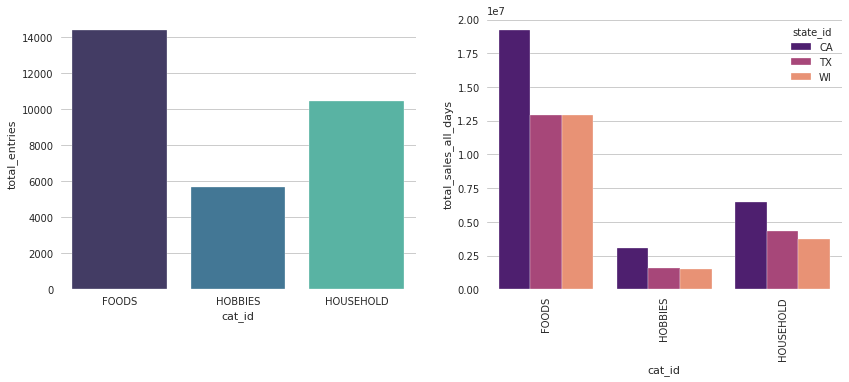

In [10]:
sns.set_style('whitegrid')
sns.axes_style(style='ticks')
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(14,5))

sns.barplot(x = 'cat_id', y='total_entries', data=df1, 
            palette='mako', ax=ax1)
sns.barplot(x = 'cat_id', y='total_sales_all_days', hue='state_id', data=df2, 
            palette='magma', ax=ax2)

plt.xticks(rotation=90)
plt.show()

Qua các biểu đồ trực quan dữ liệu phân bổ theo sản phẩm có thể cho thấy được 1 số nhận định sau:
- Mặt hàng bán chạy thuộc danh mục Thực Phẩm (Food), tiếp theo sau đó là HOUSEHOLD và HOBBIES
- CA dẫn đầu trong doanh thu ở các danh mục, tiếp theo là WISCONSIN đứa sau TX ngoại trừ mảng FOOD

Chúng ta có thể có nhìn tổng quan hơn về doanh thu, sản phẩm bán được phân bổ dựa trên danh mục ở các bang như dưới đây:

In [11]:
df = train_sales_df.groupby(['state_id', 'cat_id'])['id'].count().reset_index(name='num_sales_by_category')
fig = px.bar(df, x="state_id", y="num_sales_by_category", 
             color="cat_id", title="Distribution of Product_ids Count Across Categories & Each Locale")
fig.show()

#### Thống kê mặt hàng bán trên toàn bộ các cửa hàng
Tiếp theo, chúng ta thể hiện dữ liệu chi tiết các mặt hàng bán trên toàn bộ các cửa hàng

In [12]:
df = train_sales_df.groupby(['dept_id', 'store_id', 'state_id', 'cat_id'])[train_sales_df.columns[6:]].sum().reset_index()
df = df.sort_values('total_sales_all_days', ascending=False)

In [13]:
x_dept = df['dept_id']
x_store = df['store_id']

def items_sold_per_days(x_spec,title_text, title):
    
    '''
    returns plotly plots with drop down menus for specified parameter made in dataframe earlier
    
    inputs: x_spec (categorical feature on the x_axis), title_text(title on dropdown), 
            title (title of the plot)
            
    returns: plotly plots of categorical feature (x_axis) with dropdowns on specific 
    number of days        
    '''
    
    cols = ['d_1', 'd_50', 'd_300', 'd_500', 'd_700', 'd_900', 'd_1100', 'd_1500', 'd_1700',
        'total_sales_all_days', 'median_sales_all_days']

    buttons1 = [dict(method = "restyle",
                 args = [{'x': [x_spec, 'undefined'],
                          'y': [df[cols[k]], 'undefined'],
                          'visible':[True, False]}], 
                 label = cols[k])   for k in range(0, len(cols))]

    fig = go.Figure()
    fig.add_trace(go.Bar(x=x_spec, y = df['d_1'], name='Dept.Sales on day2',
                     marker_color='Crimson'))

    fig.update_layout(title_text= title_text,
                  title_x= 0.4, width=750, height=450, 
                  margin=dict(t=100, b=20, l=0, r=0),
                  autosize = False,
                  updatemenus=[dict(active=0,
                                    buttons=buttons1,
                                    x=0.08,
                                    y=1.13,
                                    xanchor='left',
                                    yanchor='top')
                              ]); 

    fig.add_annotation( x=0.00,  y=1.13, showarrow=False, xref='paper', yref='paper', xanchor='left',
                   text="With<br>"+str(title));
    fig.show()

items_sold_per_days(df['store_id'], 'Distribution of Sales Made on Each Store', 'Stores')
items_sold_per_days(df['state_id'], "Distribution of Sales Made In Each State", 'States')

#### Trực quan hiệu suất bán của các mặt hàng
Ta có thể kiểm tra mức độ tiêu thụ của các mặt hàng như sau:


In [14]:
 #Sắp xếp dữ liệu theo doanh thu giảm dần (dòng đầu tiên là mặt hàng bán chạy nhất)  
train_sales_df.groupby(['id'])['total_sales_all_days'].sum().sort_values(ascending=False) 

id
FOODS_3_090_CA_3_validation        250502
FOODS_3_586_TX_2_validation        192835
FOODS_3_586_TX_3_validation        150122
FOODS_3_586_CA_3_validation        134386
FOODS_3_090_CA_1_validation        127203
                                    ...  
FOODS_2_071_TX_3_validation            16
FOODS_2_057_WI_2_validation            16
HOBBIES_1_170_WI_3_validation          13
FOODS_3_778_CA_2_validation            12
HOUSEHOLD_1_020_CA_3_validation        10
Name: total_sales_all_days, Length: 30490, dtype: int64

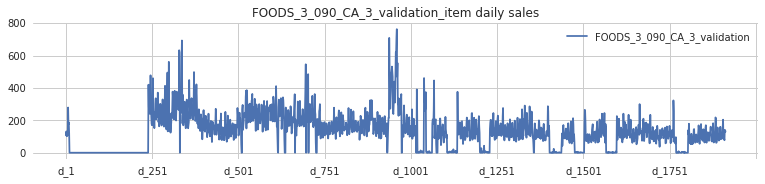

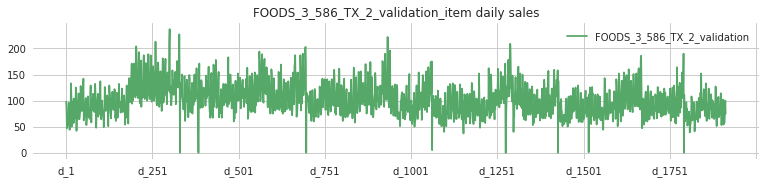

In [15]:
sns.set_style('whitegrid')

def plot_dailysales(spec_id):
    """
    plots the behavior of dailysales of specific ids i.e. spec_id
    
    input: spec_id
    returns : number of sales plotted across number of days 
    """
    train_sales_df.loc[train_sales_df['id'] == spec_id ].set_index('id')[d_cols]\
                .T\
                .plot(figsize = (13,2.5),
                      title =  str(spec_id)+"_item daily sales", 
                      color = next(color_cycle) )
    plt.legend()
    plt.show()

plot_dailysales('FOODS_3_090_CA_3_validation') 
plot_dailysales('FOODS_3_586_TX_2_validation')

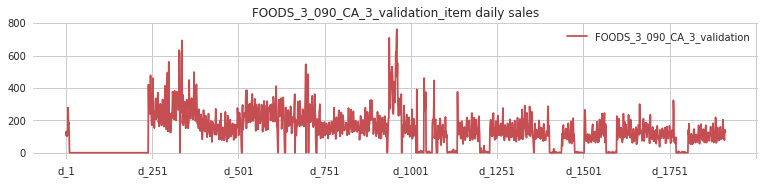

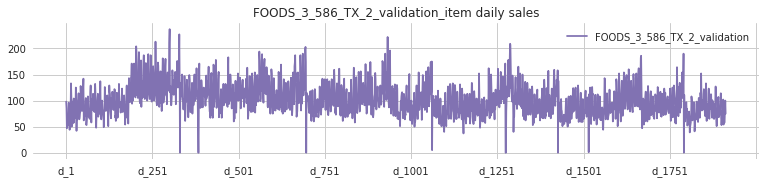

In [16]:
sns.set_style('whitegrid')

def plot_dailysales(spec_id):
    """
    plots the behavior of dailysales of specific ids i.e. spec_id
    
    input: spec_id
    returns : number of sales plotted across number of days 
    """
    train_sales_df.loc[train_sales_df['id'] == spec_id ].set_index('id')[d_cols]\
              .T.plot(figsize = (13,2.5),
                      title =  str(spec_id)+"_item daily sales", 
                      color = next(color_cycle) )
    plt.legend()
    plt.show()

plot_dailysales('FOODS_3_090_CA_3_validation') 
plot_dailysales('FOODS_3_586_TX_2_validation')

Trực quan dữ liệu về mặt hàng bán chạy nhất theo phân loại sản phẩm:

In [17]:
df_agg = pd.DataFrame(train_sales_df.groupby(['id', 'cat_id', 'store_id'])['total_sales_all_days']
                      .sum().sort_values(ascending=False))
df_agg = df_agg.reset_index()
df_agg.head(3) # Vd: Lấy top 3 sản phẩm bán chạy nhất trong danh mục FOOD

,id,cat_id,store_id,total_sales_all_days
0,FOODS_3_090_CA_3_validation,FOODS,CA_3,250502
1,FOODS_3_586_TX_2_validation,FOODS,TX_2,192835
2,FOODS_3_586_TX_3_validation,FOODS,TX_3,150122


In [18]:
# In sản phẩm bán chạy nhất trong trên cả 3 danh mục FOOD,HOUSEHOLD,HOBBIES
print("The 3 item_ids outselling most in FOODS category are: {}".format(list(df_agg.loc[df_agg['cat_id'] == 'FOODS']['id'][:3])))
print("The 3 item_ids outselling most in HOUSEHOLDS category are: {}".format(list(df_agg.loc[df_agg['cat_id'] == 'HOUSEHOLD']['id'][:3])))
print("The 3 item_ids outselling most in HOBBIES category are: {}".format(list(df_agg.loc[df_agg['cat_id'] == 'HOBBIES']['id'][:3])))

The 3 item_ids outselling most in FOODS category are: ['FOODS_3_090_CA_3_validation', 'FOODS_3_586_TX_2_validation', 'FOODS_3_586_TX_3_validation']
The 3 item_ids outselling most in HOUSEHOLDS category are: ['HOUSEHOLD_1_118_CA_3_validation', 'HOUSEHOLD_1_459_CA_3_validation', 'HOUSEHOLD_1_334_CA_3_validation']
The 3 item_ids outselling most in HOBBIES category are: ['HOBBIES_1_234_CA_3_validation', 'HOBBIES_1_348_CA_1_validation', 'HOBBIES_1_371_CA_1_validation']


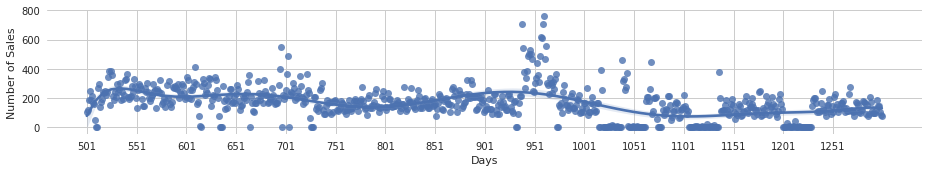

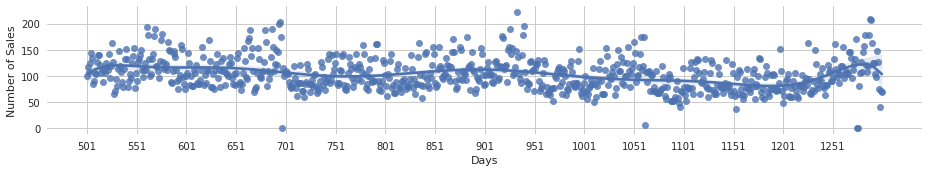

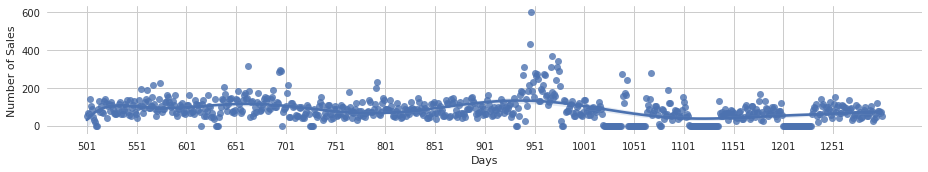

In [19]:
# df = pd.DataFrame({"days": list(train_sales_df[train_sales_df['id'] == 'FOODS_3_090_CA_3_validation'][d_cols].columns),
#                   "sales_data": list(train_sales_df[train_sales_df['id'] == 'FOODS_3_090_CA_3_validation'][d_cols].values.flatten())})

#fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(14, 7))

def plot_sample_sales(spec_id, sm_start, sm_end, samples_pick=50):
    """
    plots sample sales data with selection point and ending point specified, along with
    samples_pick point that specifies the samples picked after specified intervals
    
    input: spec_id (item_id or id), sm_start (sample_start), sm_end(sample_end),
    samples_pick (samples picked after how many intervals)
    
    returns: outputs a graph of sample points plotted against daily sales data d_1 to d_1913
    """
    fig, ax1 = plt.subplots(figsize=(13, 2.5))
    
    x1 = list(train_sales_df[train_sales_df['id'] == spec_id][d_cols]\
              .columns)[sm_start:sm_end]
    y1 = list(train_sales_df[train_sales_df['id'] == spec_id][d_cols]\
              .values.flatten())[sm_start:sm_end]
    
    #this conversion for regplot only
    x1 = [x.replace("d_", "") for x in x1]
    x1 = [int(x) for x in x1]
    
    #sns.lineplot(x=x1, y=y1, ax=ax1)
    sns.regplot(x=x1, y=y1, order=10, ax=ax1)
    ax1.set_ylabel("Number of Sales")
    ax1.set_xlabel("Days")

    ax1.set_xticks(x1[::samples_pick])
    ax1.set_xticklabels(x1[::samples_pick], rotation=0)

    fig.tight_layout()
    plt.show()
    
plot_sample_sales('FOODS_3_090_CA_3_validation', 500, 1300)
plot_sample_sales('FOODS_3_586_TX_2_validation', 500, 1300)
plot_sample_sales('FOODS_3_090_CA_1_validation', 500, 1300)

### Phân tích dữ liệu doanh thu bán hàng

In [20]:
sell_prices_df.head(3)

,store_id,item_id,wm_yr_wk,sell_price
0,CA_1,HOBBIES_1_001,11325,9.58
1,CA_1,HOBBIES_1_001,11326,9.58
2,CA_1,HOBBIES_1_001,11327,8.26


In [21]:
# making a new column category out of the item_id 
sell_prices_df['category'] = sell_prices_df['item_id'].str.split("_", expand=True)[0]

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



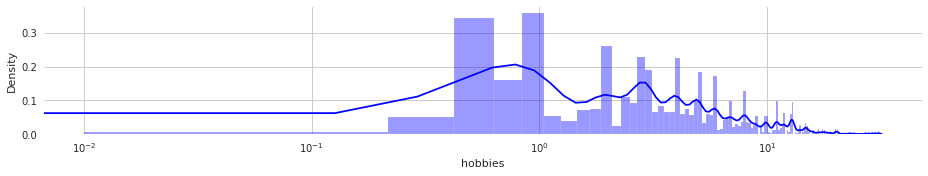

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



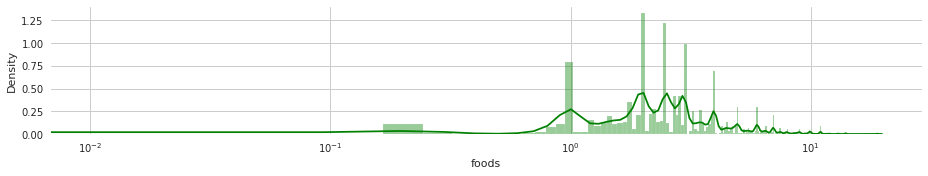

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



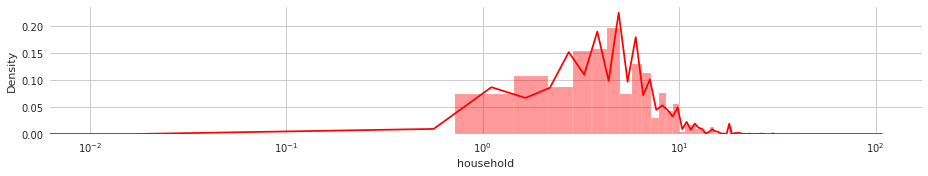

In [22]:
sns.set_style('whitegrid')
#plt.figure(figsize=(15,5))

def kde_plotting(df, category, bin_size, color, label):
    
    '''
    plots the kde density plot of the continuous features of df specified
    
    inputs: df, category(whether, foods, household or hobbies), bin_size(bin size for histogram)
            color (color of the plot), label (label to the plot)
    returns: kde plots with logarithmic scale taken on x_axis
            
    '''
    fig, ax1 = plt.subplots(figsize=(13, 2.5) )

    # distplot is a deprecated function, nếu có warning không ảnh hưởng đến kết quả, latest version đã fix issue này
    sns.distplot(df[df['category'] == category]['sell_price'], 
               axlabel = label ,bins=bin_size, color = color, ax=ax1) 

    fig.tight_layout()
    ax1.set_xscale('log')
    plt.legend()
    plt.show()
    
kde_plotting(sell_prices_df, 'HOBBIES', 150, 'b', 'hobbies')   
kde_plotting(sell_prices_df, 'FOODS', 250, 'g', 'foods') 
kde_plotting(sell_prices_df, 'HOUSEHOLD', 150, 'r', 'household') 

#### Khử nhiễu dữ liệu bằng Tứ phân vị (Quartile)
Dùng phương pháp Tứ phân vị (Quartile) để loại bỏ các dữ liệu tạp cho các bước phân tích tiếp theo

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning:

Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version.  Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning:

Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version.  Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`



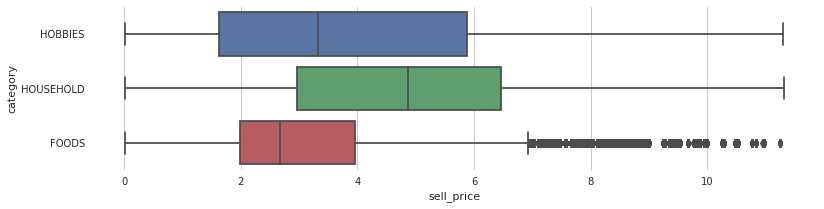

In [59]:
def remove_outliers(df): 
    Q1=df.quantile(0.25)
    Q3=df.quantile(0.75)
    IQR=Q3-Q1
    df_final=df[~((df<(Q1-1.5*IQR)) | (df>(Q3+1.5*IQR)))]
    
    return df_final
    
#----------Lọc dữ liệu
df = sell_prices_df[['category', 'sell_price']]
df = remove_outliers(df)

#----------Vẽ biểu đồ

sns.set_style('whitegrid')
sns.axes_style(style='ticks')
plt.figure(figsize=(13,3))
sns.boxplot(y=df['category'], x=df['sell_price'])
plt.show()

#### Trực quan dữ liệu bán hàng vào cuối tuần và ngày lễ/ ngày đặc biệt




In [24]:
# Check dữ liệu (can ignored)
calendar_df.head(3)
calendar_df.groupby(['event_name_1', 'event_type_1'])['wday'].count()
calendar_df.groupby(['event_name_2', 'event_type_2'])['wday'].count()

event_name_2    event_type_2
Cinco De Mayo   Cultural        1
Easter          Cultural        1
Father's day    Cultural        2
OrthodoxEaster  Religious       1
Name: wday, dtype: int64

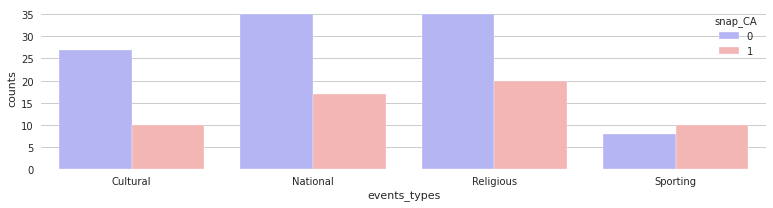

In [25]:
#Making in and including a new entry of days as well as merging the events_1 and event_2 into
# a single new events_names and types category

calendar_df['days'] = [d.split('-')[2] for d in calendar_df['date']]
calendar_df['events_names'] = pd.concat([calendar_df['event_name_1'], calendar_df['event_name_2']], 
                                        ignore_index=True)
calendar_df['events_types'] = pd.concat([calendar_df['event_type_1'], calendar_df['event_type_2']], 
                                        ignore_index=True)
#calendar_df.drop(['event_name_1', 'event_name_2', 'event_type_1', 'event_type_2'], axis=1, inplace=True)
df = calendar_df.groupby(['events_types'])['snap_CA'].value_counts().reset_index(name='counts')

#----------Vẽ biểu đồ
sns.set_style('whitegrid')
sns.axes_style(style='ticks')
plt.figure(figsize=(13,3))
sns.barplot(x = 'events_types', y='counts', hue='snap_CA', data=df, palette='bwr')
plt.show()

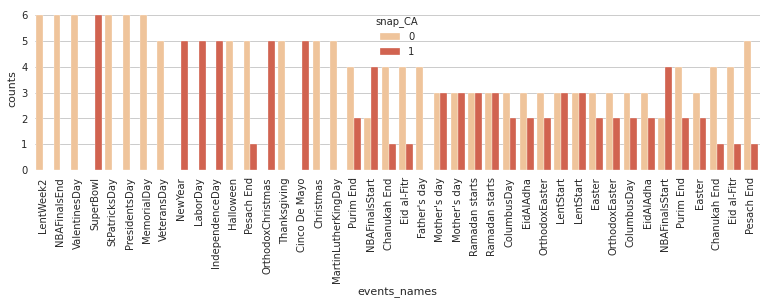

In [26]:
#product id df (train_sales_df) vs revenue_df(sell_prices_df)
df = calendar_df.groupby(['events_names'])['snap_CA'].value_counts().reset_index(name='counts')
sns.set_style('whitegrid')
sns.axes_style(style='ticks')
plt.figure(figsize=(13,3))
sns.barplot(x = 'events_names', y='counts', hue='snap_CA', data=df, 
            order = df.sort_values(['counts'], ascending=False).events_names, 
            palette='OrRd')
plt.xticks(rotation=90)
plt.show()
# train_sales_cal_df.T

#### Trực quan dữ liệu các mặt hàng bán so với doanh thu

In [60]:
train_sales_df.head(3)


,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913,total_sales_all_days,avg_sales_all_days,median_sales_all_days
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,1,1,3,0,1,1,600,0.313643,0.0
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,1,0,0,0,0,493,0.257710,0.0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,1,1,0,1,1,1,288,0.150549,0.0


In [61]:
sell_prices_df.head(3)

,store_id,item_id,wm_yr_wk,sell_price,category
0,CA_1,HOBBIES_1_001,11325,9.58,HOBBIES
1,CA_1,HOBBIES_1_001,11326,9.58,HOBBIES
2,CA_1,HOBBIES_1_001,11327,8.26,HOBBIES


In [62]:
#product id df (train_sales_df) vs revenue_df(sell_prices_df)
# train_sales_prices_df = train_sales_df.merge(sell_prices_df, how='inner', on='item_id', 
#                                             left_index=True, right_index=True, 
#                                             validate="1:1")
#Join 2 data frame dữ liệu trên với item_id là khóa
train_sales_prices_df = pd.merge(train_sales_df, sell_prices_df, how='inner', left_index=True, right_index=True)

In [65]:
#---------------
df = train_sales_prices_df.groupby(['cat_id', 'state_id', 'store_id_x'])['sell_price'].sum().reset_index(name='total_revenue')
df = df.sort_values(by='total_revenue', ascending=False)
# df

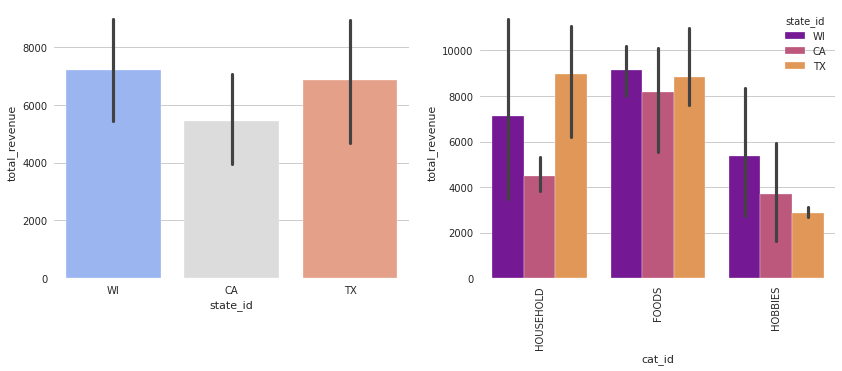

In [66]:


#-------------Vẽ biểu đồ dùng seanborn
sns.set_style('whitegrid')
sns.axes_style(style='ticks')
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(14,5))

sns.barplot(x = 'state_id', y='total_revenue', data=df, 
            palette='coolwarm', ax=ax1)
sns.barplot(x = 'cat_id', y='total_revenue', hue='state_id', data=df, 
            palette='plasma', ax=ax2)

plt.xticks(rotation=90)
plt.show()

### Phân tích dữ liệu bán hàng theo chuỗi thời gian

In [32]:
# train_sales_cal_df = train_sales_df.set_index('id')[d_cols].T.merge(calendar_df.set_index('d'), 
#                                                                    left_index=True, right_index=True,
#                                                                    validate="1:1").set_index('date')
# train_sales_cal_df.T

#### Trực quan dữ liệu tổng doanh thu bán hàng của sản phẩm theo chuỗi thời gian 


In [67]:
# Filter doanh số bán hàng theo ngày
train_sales_cal_df = train_sales_df.set_index('id')[d_cols].T.merge(calendar_df.set_index('d')['date'], 
                                                                    left_index=True, right_index=True,
                                                                    validate="1:1").set_index('date')
# thêm cột tổng doanh thu theo ngày và giá trị là tổng giá trị sản phẩm bán trong ngày
train_sales_cal_df['total_sales'] = train_sales_cal_df.sum(axis=1)
train_sales_cal_df.head(3)

,HOBBIES_1_001_CA_1_validation,HOBBIES_1_002_CA_1_validation,HOBBIES_1_003_CA_1_validation,HOBBIES_1_004_CA_1_validation,HOBBIES_1_005_CA_1_validation,HOBBIES_1_006_CA_1_validation,HOBBIES_1_007_CA_1_validation,HOBBIES_1_008_CA_1_validation,HOBBIES_1_009_CA_1_validation,HOBBIES_1_010_CA_1_validation,...,FOODS_3_819_WI_3_validation,FOODS_3_820_WI_3_validation,FOODS_3_821_WI_3_validation,FOODS_3_822_WI_3_validation,FOODS_3_823_WI_3_validation,FOODS_3_824_WI_3_validation,FOODS_3_825_WI_3_validation,FOODS_3_826_WI_3_validation,FOODS_3_827_WI_3_validation,total_sales
date,,,,,,,,,,,,,,,,,,,,,
2011-01-29,0,0,0,0,0,0,0,12,2,0,...,14,1,0,4,0,0,0,0,0,32631
2011-01-30,0,0,0,0,0,0,0,15,0,0,...,11,1,0,4,0,0,6,0,0,31749
2011-01-31,0,0,0,0,0,0,0,0,7,1,...,5,1,0,2,2,0,0,0,0,23783


In [34]:
#Changing the date type to datetime so that it is depicted as so:
#calendar_df.date = pd.to_datetime(calendar_df.date)
#type(calendar_df.date)

#------------- Thống kê dữ liệu để vẽ
train_sales_cal_df['total_sales'] = train_sales_cal_df.sum(axis=1)
train_sales_cal_df = train_sales_cal_df[['total_sales']]
train_sales_cal_df = train_sales_cal_df.reset_index()

In [35]:
#-------------- Vẽ biểu đồ
fig = px.line(train_sales_cal_df, x='date', y="total_sales", 
             template = 'plotly_white', title = 'Total Sales by Product id', 
             width=800, height=450)

fig.update_xaxes(rangeslider_visible=True)
fig.update_layout(
    xaxis=dict(
    rangeselector=dict( buttons=list([ dict(count=1, label="1m", step="month", stepmode="backward"),
    dict(count=6,label="6m", step="month", stepmode="backward"),
    dict(count=1, label="YTD", step="year", stepmode="todate"),
    dict(count=1, label="1y", step="year", stepmode="backward"),
    dict(step="all")
            ]) 
                      ),
        rangeslider=dict(
            visible=True
        ),
        type="date"
    )
)

fig.show()

#### Phân tích theo xu hướng doanh thu

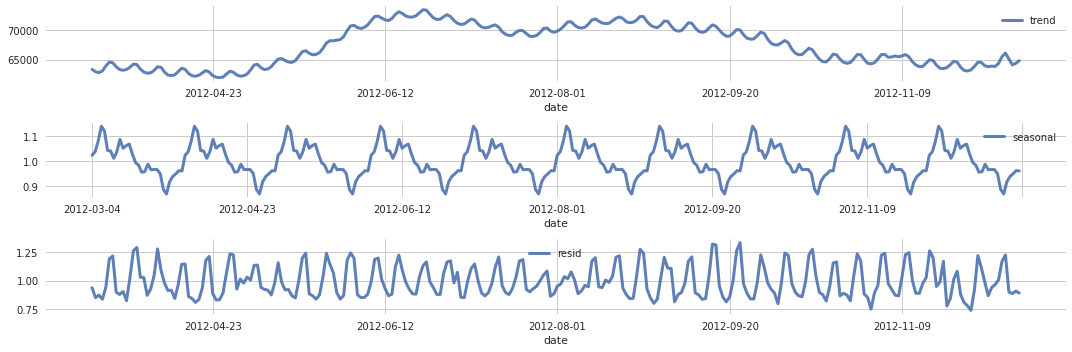

In [36]:
from statsmodels.tsa.seasonal import seasonal_decompose

def time_series_decompose(df, model_specified, period):

    '''
    returns decomposed time series components (with seasonality, trend and residuals ) of time_series df
    
    inputs: 
    df(time series df),  => dataframe dữ liệu đầu vào
    model_specified (whether additive or multiplicative),  => loại xu hướng phần tích
    period(number of days) => số ngày 
    returns: trend values, seasonality values and residual values of time_series df => output trả về 3 df
    
    '''
    df_decomposition = seasonal_decompose(
                               x=df.set_index(['date']), 
                               model= model_specified, 
                               period=period)
    
    est_trend = df_decomposition.trend
    est_trend = est_trend.reset_index(name='trend').set_index('date')
    est_seasonal = df_decomposition.seasonal
    est_seasonal = est_seasonal.reset_index(name='seasonal').set_index('date')
    est_residual = df_decomposition.resid
    est_residual = est_residual.reset_index(name='resid').set_index('date')
    
    return est_trend, est_seasonal, est_residual

sample_time_s1 = train_sales_cal_df[400:700]
est_trend, est_seasonal, est_residual = time_series_decompose(sample_time_s1, 'multiplicative', 30)

#-------------- Dùng matplotlib.pyplot để vẽ các biểu đồ 

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(14, 7))

est_trend.plot(figsize=(15, 5) ,
                 alpha=0.9, 
                 lw=3, ax = ax1)
est_seasonal.plot(figsize=(15, 5) ,
                 alpha=0.9, 
                 lw=3, ax = ax2)
est_residual.plot(figsize=(15, 5) ,
                 alpha=0.9, 
                 lw=3, ax = ax3)

fig.tight_layout()
plt.show()

#### Phân tích doanh thu bán hàng với giá trị trung bình

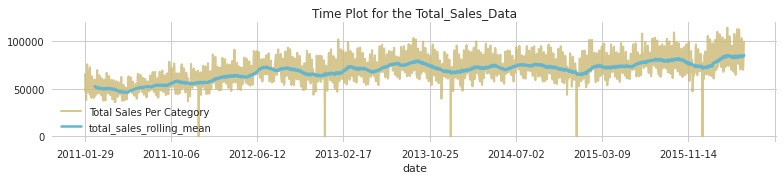

In [37]:
train_sales_cal_df = train_sales_cal_df.set_index('date')

#-------------------
def time_and_rolling_plot(df, title_text, rolling_days=30, height=2.2):

    '''
    plots the time_series of dailysales made along with rolling mean plot
    
    inputs: df, title_text(plot title), rolling_days (rolling mean to be taken across), 
            height(height of the plot to be specified)
            
    returns: time series plot and rolling mean plot of the variable specified 
    '''
    sns.set_style('whitegrid')
    fig, ax1 = plt.subplots(1, 1, figsize=(13, height))
    df.plot(figsize=(13, height),
                        alpha=0.8,
                        title="Time Plot for the " + str(title_text), 
                        lw=2, color=next(color_cycle), ax=ax1)
    df.rolling(rolling_days).mean().plot(figsize=(13, height),
                                          alpha=1, 
                                          legend="Rolling Mean on 30 days", 
                                          lw=2.5, color=next(color_cycle), ax=ax1)
    ax1.legend(['Total Sales Per Category', 'total_sales_rolling_mean'])
    plt.show()

time_and_rolling_plot(train_sales_cal_df, 'Total_Sales_Data')


In [38]:
#finding the product_ids of 25 most sold units
train_sales_most_sold_25 = train_sales_df.groupby(['id'])['total_sales_all_days'].sum().sort_values(ascending=False)[:25]
train_sales_most_sold_25 = train_sales_most_sold_25.reset_index(name='total_sales')
train_sales_most_sold_25.iloc[0:5]

,id,total_sales
0,FOODS_3_090_CA_3_validation,250502
1,FOODS_3_586_TX_2_validation,192835
2,FOODS_3_586_TX_3_validation,150122
3,FOODS_3_586_CA_3_validation,134386
4,FOODS_3_090_CA_1_validation,127203


In [39]:
train_sales_most_sold_25['state'] = train_sales_most_sold_25['id'].str.split("_", expand=True)[3]
train_sales_most_sold_25.groupby(['state'])['total_sales'].sum().sort_values(ascending=False)

state
TX    1233196
CA    1005717
WI     470367
Name: total_sales, dtype: int64

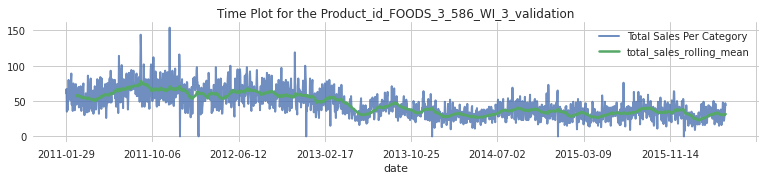

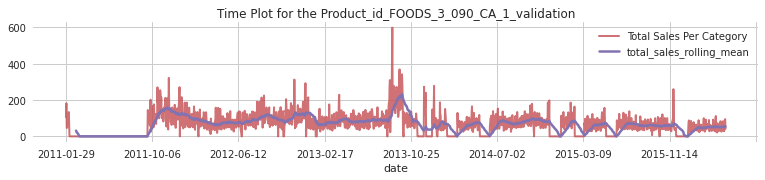

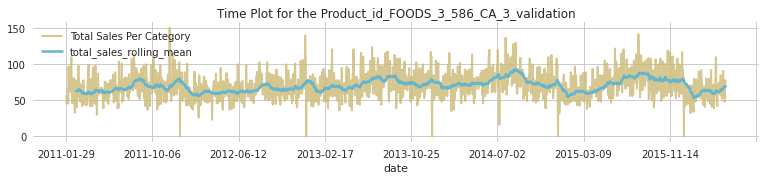

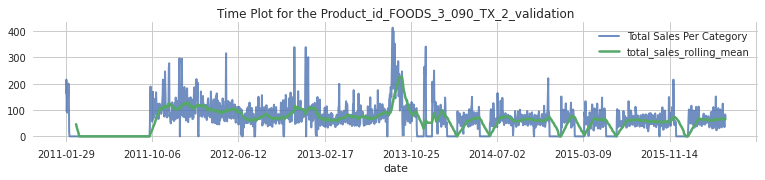

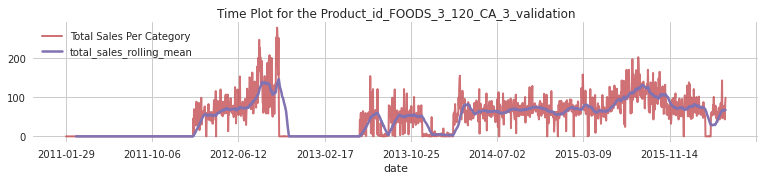

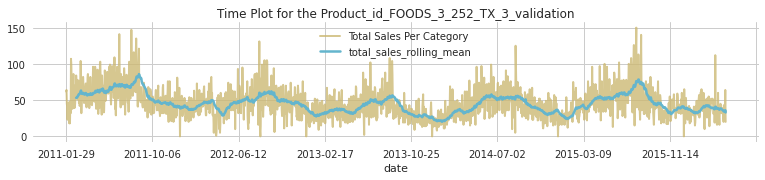

In [40]:
train_sales_cal_df = train_sales_df.set_index('id')[d_cols].T.merge(calendar_df.set_index('d')['date'], 
                                                                    left_index=True, right_index=True,
                                                                    validate="1:1").set_index('date')

#--------------
# print('FOODS_3_586_WI_3_validation')
time_and_rolling_plot(train_sales_cal_df[['FOODS_3_586_WI_3_validation']], "Product_id_FOODS_3_586_WI_3_validation")
# print('FOODS_3_090_CA_1_validation')
time_and_rolling_plot(train_sales_cal_df[['FOODS_3_090_CA_1_validation']], "Product_id_FOODS_3_090_CA_1_validation")
# print('FOODS_3_586_CA_3_validation')
time_and_rolling_plot(train_sales_cal_df[['FOODS_3_586_CA_3_validation']], "Product_id_FOODS_3_586_CA_3_validation")
# print('FOODS_3_090_TX_2_validation')
time_and_rolling_plot(train_sales_cal_df[['FOODS_3_090_TX_2_validation']], "Product_id_FOODS_3_090_TX_2_validation")
# print('FOODS_3_120_CA_3_validation')
time_and_rolling_plot(train_sales_cal_df[['FOODS_3_120_CA_3_validation']], "Product_id_FOODS_3_120_CA_3_validation")
# print('FOODS_3_252_TX_3_validation')
time_and_rolling_plot(train_sales_cal_df[['FOODS_3_252_TX_3_validation']], "Product_id_FOODS_3_252_TX_3_validation")                                                         

#### Trực quan dữ liệu tổng doanh thu bán hàng theo danh mục sản phẩm

In [41]:
# Join dữ liệu train_sales_df và calendar_df theo cat_id
train_sales_cal_df = (train_sales_df.groupby(["cat_id"])[d_cols].sum()
                    .T.merge(
                        calendar_df.set_index("d")["date"],
                        left_index=True,
                        right_index=True,
                        validate="1:1",
                    ).set_index("date"))

train_sales_cal_df.head(3)


,FOODS,HOBBIES,HOUSEHOLD
date,,,
2011-01-29,23178,3764,5689
2011-01-30,22758,3357,5634
2011-01-31,17174,2682,3927


In [42]:
def plotly_time_plot_markers(df, text, samples_onwards=1000):

    '''
    plots time_series plotly scatter plot of the format specified in df 
    
    inputs: df(dataframe), text(title text ), samples_onwards (time_series_sample and the end)
    returns : plotly time series scatter plot
    
    '''
    fig = go.Figure()
    for c in df.columns[:4]:
        fig.add_traces(go.Scatter(x=train_sales_cal_df[samples_onwards:].index, 
                              y=train_sales_cal_df[samples_onwards:][c],
                              mode='markers',
                              name = c))

    fig.update_layout( title = 'Sales per Day by ' + str(text), template = 'plotly_white',
        width=750, height=550,
        xaxis_tickformatstops = [
            dict(dtickrange=["M1", "M12"], value="%b '%y"),
        ]
    )
    
    fig.update_layout(
    xaxis=dict(
    rangeselector=dict( buttons=list([ dict(count=1, label="1m", step="month", stepmode="backward"),
    dict(count=6,label="6m", step="month", stepmode="backward"),
    dict(count=1, label="YTD", step="year", stepmode="todate"),
    dict(count=1, label="1y", step="year", stepmode="backward"),
    dict(step="all") ])  ),
        rangeslider=dict(
            visible=True
        ),
        type="date" ) )

    fig.update_xaxes(rangeslider_visible=True)    
    fig.show()    

plotly_time_plot_markers(train_sales_cal_df, 'Category')  

#### Trực quan dữ liệu tổng doanh thu bán hàng theo các bang 

In [43]:
train_sales_cal_df = train_sales_df.groupby(['state_id'])[d_cols].sum().T.merge(calendar_df.set_index('d')['date'], 
                                                                    left_index=True, right_index=True,
                                                                    validate="1:1").set_index('date')
#train_sales_cal_df = train_sales_cal_df.reset_index()
train_sales_cal_df

,CA,TX,WI
date,,,
2011-01-29,14195,9438,8998
2011-01-30,13805,9630,8314
2011-01-31,10108,6778,6897
2011-02-01,11047,7381,6984
2011-02-02,9925,5912,3309
...,...,...,...
2016-04-20,15148,9600,10595
2016-04-21,14488,9602,10943
2016-04-22,17095,10615,12807


In [44]:
from plotly.subplots import make_subplots

def plotly_time_plot_rolling(df, text, start_col=0, end_col=3, rolling_days=30):

    '''
    time series rolling plots of the categories specified in df
    inputs: df (dataframe with ts as index, and columns as categories), text (title of the plot)
            rolling_days (number of rolling days)
    
    returns: plotly time series plot of sales along the categories specified as columns in df
    '''
    fig = go.Figure()
    for c in df.columns[start_col:end_col]:
        fig.add_traces(go.Scatter(x=df.rolling(rolling_days).mean().index, 
                              y=df.rolling(rolling_days).mean()[c],
                              mode='lines+markers',
                              name = c))

    fig.update_layout( title = 'Sales per Day by ' + str(text), template = 'plotly_white',
        width=750, height=550,
        xaxis_tickformatstops = [
            dict(dtickrange=["M1", "M12"], value="%b '%y"),
        ]
    )
    
    fig.update_layout(
    xaxis=dict(
    rangeselector=dict( buttons=list([ dict(count=1, label="1m", step="month", stepmode="backward"),
    dict(count=6,label="6m", step="month", stepmode="backward"),
    dict(count=1, label="YTD", step="year", stepmode="todate"),
    dict(count=1, label="1y", step="year", stepmode="backward"),
    dict(step="all") ])  ),
        rangeslider=dict(
            visible=True
        ),
        type="date" ) )

    fig.update_xaxes(rangeslider_visible=True)    
    fig.show()   

plotly_time_plot_rolling(train_sales_cal_df, 'State')

In [45]:
#referring to the solution provided at https://stackoverflow.com/questions/43223615/join-dataframes-one-with-multiindex-columns-and-the-other-without

train_sales_cal_df = train_sales_df.groupby(['state_id', 'cat_id'])[d_cols].sum().T.join(pd.concat([calendar_df.set_index('d')['date']], axis=1, keys=['dates']))
train_sales_cal_df.head(2)

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:648: UserWarning:

merging between different levels can give an unintended result (2 levels on the left,1 on the right)



,"(CA, FOODS)","(CA, HOBBIES)","(CA, HOUSEHOLD)","(TX, FOODS)","(TX, HOBBIES)","(TX, HOUSEHOLD)","(WI, FOODS)","(WI, HOBBIES)","(WI, HOUSEHOLD)",dates
d_1,10101,1802,2292,6853,879,1706,6224,1083,1691,2011-01-29
d_2,9862,1561,2382,7030,870,1730,5866,926,1522,2011-01-30


CA(California) FOODS, HOBBIES and HOUSEHOLD


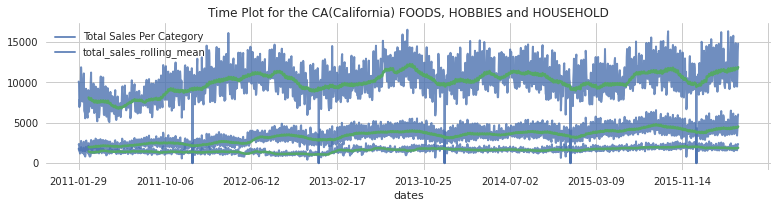

TX(Texas) FOODS, HOBBIES and HOUSEHOLD


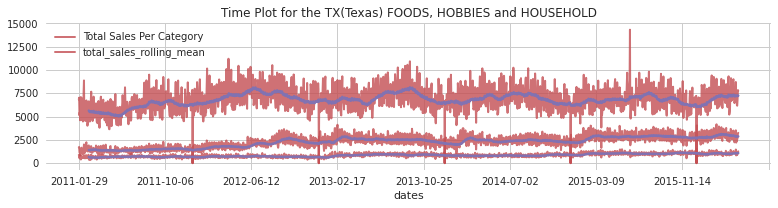

WI(Wisconsin) FOODS, HOBBIES and HOUSEHOLD


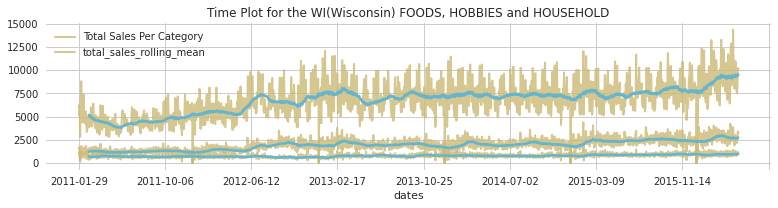

In [46]:
#train_sales_cal_df = train_sales_cal_df.set_index('dates')
select_cols_ca = [c for c in train_sales_cal_df.columns if 'CA' in c]
select_cols_tx = [c for c in train_sales_cal_df.columns if 'TX' in c]
select_cols_wi = [c for c in train_sales_cal_df.columns if 'WI' in c]
#train_sales_df['total_sales_all_days'] = train_sales_df[d_cols].sum(axis = 1)
#train_sales_cal_df = 
df_CA = train_sales_cal_df.set_index('dates')[select_cols_ca]
df_TX = train_sales_cal_df.set_index('dates')[select_cols_tx]
df_WI = train_sales_cal_df.set_index('dates')[select_cols_wi]

#df_CA.columns = [col[1] for col in df_CA.columns]
#df_TX.columns = [col[1] for col in df_TX.columns]
#df_WI.columns = [col[1] for col in df_WI.columns]
print('CA(California) FOODS, HOBBIES and HOUSEHOLD')
time_and_rolling_plot(df_CA, 'CA(California) FOODS, HOBBIES and HOUSEHOLD', height=2.7)

print('TX(Texas) FOODS, HOBBIES and HOUSEHOLD')
time_and_rolling_plot(df_TX, 'TX(Texas) FOODS, HOBBIES and HOUSEHOLD', height=2.7)

print('WI(Wisconsin) FOODS, HOBBIES and HOUSEHOLD')
time_and_rolling_plot(df_WI, 'WI(Wisconsin) FOODS, HOBBIES and HOUSEHOLD', height=2.7)
#time_and_rolling_plot(df_CA.iloc[:,1].reset_index(), "CA HOBBIES")
#time_and_rolling_plot(df_CA.iloc[:,2].reset_index(), "CA State")

In [47]:
train_sales_cal_df = train_sales_df.set_index('id')[d_cols].T.merge(calendar_df.set_index('d')['date'], 
                                                                    left_index=True, right_index=True,
                                                                    validate="1:1").set_index('date')
train_sales_cal_df['total_sales'] = train_sales_cal_df.sum(axis=1)

#----------
item_ids = [c for c in train_sales_cal_df.columns if 'validation' in c]

#----------
train_sales_cal_df = train_sales_cal_df.reset_index()
train_sales_cal_df['date'] = pd.to_datetime(train_sales_cal_df['date'])
train_sales_cal_df['month'] = train_sales_cal_df.date.dt.month
train_sales_cal_df['year'] = train_sales_cal_df.date.dt.year
df = train_sales_cal_df.groupby(['year', 'month'])[item_ids].sum()
df = df.reset_index()

#-----------
def find_items_per_specific_date(df, year, month, category, number):
    
    '''
    finds the five most sold product_ids in user specified category, year and month
    
    inputs: df(item_ids along with year and month), year, month, category (household, 
    foods or hobbies), number (how many results to be displayed)
    
    returns : table of product ids with specfied number and date and number of sales made
    '''
    
    df = df.loc[(df['year'] == year) & (df['month'] == month)][item_ids].T.reset_index()
    df.columns = ['item_id', 'sales_count']
    df = df.set_index('item_id')
    item_type = [c for c in df.index if category in c]
    df = df[df.index.isin(item_type)]
    df = df.sort_values(by = ['sales_count'], ascending=False)[:number]
    
    return df

print("Most sold Foods during requested date\n"
      ,find_items_per_specific_date(df, 2012, 7, 'FOODS', 5) )
print("Most sold Household items during requested date\n" 
      ,find_items_per_specific_date(df, 2013, 3, 'HOUSEHOLD', 5) )


Most sold Foods during requested date
                              sales_count
item_id                                 
FOODS_3_090_CA_3_validation         8054
FOODS_3_281_CA_3_validation         3851
FOODS_3_586_TX_2_validation         3458
FOODS_3_120_CA_3_validation         2940
FOODS_3_090_CA_1_validation         2780
Most sold Household items during requested date
                                  sales_count
item_id                                     
HOUSEHOLD_1_334_CA_3_validation         1346
HOUSEHOLD_1_118_CA_3_validation         1253
HOUSEHOLD_1_351_CA_3_validation         1043
HOUSEHOLD_1_277_CA_3_validation         1014
HOUSEHOLD_1_334_TX_1_validation          914


#### Trực quan dữ liệu tổng doanh thu bán hàng theo cửa hàng



In [48]:
train_sales_cal_df = train_sales_df.groupby(['store_id'])[d_cols].sum().T.merge(calendar_df.set_index('d')['date'], 
                                                        left_index=True, right_index=True,
                                                        validate="1:1").set_index('date')
#----------------
train_sales_cal_df.head(2)

,CA_1,CA_2,CA_3,CA_4,TX_1,TX_2,TX_3,WI_1,WI_2,WI_3
date,,,,,,,,,,
2011-01-29,4337,3494,4739,1625,2556,3852,3030,2704,2256,4038
2011-01-30,4155,3046,4827,1777,2687,3937,3006,2194,1922,4198


In [49]:
#PLOT one by one to avoid memory overload
#plotly_time_plot_rolling(train_sales_cal_df, 'Store')
plotly_time_plot_rolling(train_sales_cal_df, 'Store', start_col=4, end_col=7)
#plotly_time_plot_rolling(train_sales_cal_df, 'Store', start_col=7, end_col=10)

#### Trực quan dữ liệu tổng doanh thu bán hàng theo thời gian chỉ định

In [50]:
train_sales_cal_df = train_sales_df.groupby(['cat_id'])[d_cols].sum().T.merge(calendar_df.set_index('d')['date'], 
                                                                    left_index=True, right_index=True,
                                                                    validate="1:1").set_index('date')
train_sales_cal_df = train_sales_cal_df.reset_index()
train_sales_cal_df['date'] = pd.to_datetime(train_sales_cal_df['date'])
train_sales_cal_df['month'] = train_sales_cal_df.date.dt.month
train_sales_cal_df['day'] = train_sales_cal_df.date.dt.day
train_sales_cal_df['year'] = train_sales_cal_df.date.dt.year
train_sales_cal_df['weekday'] = train_sales_cal_df.date.dt.weekday
train_sales_cal_df['weekday'] = train_sales_cal_df.date.dt.day_name()
train_sales_cal_df.head(2)

,date,FOODS,HOBBIES,HOUSEHOLD,month,day,year,weekday
0,2011-01-29,23178,3764,5689,1,29,2011,Saturday
1,2011-01-30,22758,3357,5634,1,30,2011,Sunday


In [51]:
df_food = train_sales_cal_df.groupby(['weekday', 'day'])['FOODS'].sum().reset_index(name='sales')
df_house = train_sales_cal_df.groupby(['weekday', 'day'])['HOUSEHOLD'].sum().reset_index(name='sales')
df_hob = train_sales_cal_df.groupby(['weekday', 'day'])['HOBBIES'].sum().reset_index(name='sales')

#---------------------------
def heatmap_plot_dates(df, title_text):

    '''
    returns the heatmap based plot for the df with time_series data in it
    
    inputs : df (dataframe with time based elements, such as weekdays, months etc.)
             title_text (text of the plot to be shown)
    returns : Heatmaps of Weekdays along number of days of a months
    '''
    fig = make_subplots(rows=1, cols=1, vertical_spacing = 0.15, 
                    subplot_titles=title_text,
                    shared_yaxes = True
                   )
    fig.add_trace( go.Heatmap(
                   z=[[df.loc[(df['day'] == day) & (df['weekday'] == weekday)]['sales'].sum()
                     for day in range(1, 31+1)] for weekday in df.weekday.unique()],
                   x=list(df.day.unique()),
                   y=list(df.weekday.unique()),
                   hoverongaps = False, 
                   colorbar = dict(title= title_text + '_Sales', 
                                   thickness=15)), row=1, col=1)
    fig.update_layout(title = title_text + '_Sale Distribution', height=2 * 20 + 300, width=1 * 700, showlegend=False)
    fig.show()


#---------------------------

heatmap_plot_dates(df_food, 'FOODS')
heatmap_plot_dates(df_hob, 'HOBBIES')
heatmap_plot_dates(df_house, 'HOUSEHOLD')

# Continue ....

## **Dự đoán theo chuỗi thời gian**

#### Chuỗi thời gian ổn định (Stationary Time Series)
Đơn giản hiểu là một chuỗi lặp đi lặp lại theo một chu kỳ, giá trị không tăng theo thời gian. Dự đoán chuỗi có tính ổn định rất dễ do có các đặc tính như: mean, variance, autocorrelation, 
Với hầu hết các phương pháp thống kê dự báo, ta đều phải đảm bảo tính dừng của chuỗi dữ liệu vì thế việc kiểm tra tính dừng là rất quan trọng.

In [87]:
train_sales_cal_df = train_sales_df.set_index('id')[d_cols].T.merge(calendar_df.set_index('d')['date'], 
                                                                    left_index=True, right_index=True,
                                                                    validate="1:1")
train_sales_cal_df['avg_sales'] = train_sales_cal_df.mean(axis=1)

In [89]:
# train_sales_cal_df = train_sales_cal_df[['total_sales']]
# train_sales_cal_df = train_sales_cal_df.reset_index()
# train_sales_cal_df = train_sales_cal_df.set_index('date')

train_sales_cal_df = train_sales_cal_df.reset_index()
train_sales_cal_df.rename(columns={'index': 'daysnum'}, inplace=True)
train_sales_cal_df.set_index('date').asfreq('d')
train_sales_cal_df.head(2)

,daysnum,daysnum,HOBBIES_1_001_CA_1_validation,HOBBIES_1_002_CA_1_validation,HOBBIES_1_003_CA_1_validation,HOBBIES_1_004_CA_1_validation,HOBBIES_1_005_CA_1_validation,HOBBIES_1_006_CA_1_validation,HOBBIES_1_007_CA_1_validation,HOBBIES_1_008_CA_1_validation,...,FOODS_3_820_WI_3_validation,FOODS_3_821_WI_3_validation,FOODS_3_822_WI_3_validation,FOODS_3_823_WI_3_validation,FOODS_3_824_WI_3_validation,FOODS_3_825_WI_3_validation,FOODS_3_826_WI_3_validation,FOODS_3_827_WI_3_validation,date,avg_sales
0,0,d_1,0,0,0,0,0,0,0,12,...,1,0,4,0,0,0,0,0,2011-01-29,1.070220
1,1,d_2,0,0,0,0,0,0,0,15,...,1,0,4,0,0,6,0,0,2011-01-30,1.041292


In [90]:
train_sales_cal_df.index = pd.to_datetime(train_sales_cal_df.index)
type(train_sales_cal_df.index)

pandas.core.indexes.datetimes.DatetimeIndex

In [91]:

def time_series_stationary_test(df):
    
    '''
    returns time_series plots along with rolling mean plot, standard_dev calculated plot
    and results of the Dickey_Fuller Test performed on time_series df
    
    inputs: df (time_series based df)
    
    returns : time_series plot, rolling_mean plot, std_plot and Dickey_Fuller Test Statistics
              performed on time_series
    '''
    #df_filter = df.loc[df['id'] == series_ids][d_cols]
    #df_filter = df.loc[df['id'] == series_ids]['sold']
    #df_filter = pd.Series(df_filter.values.flatten())
    
    sns.set_style("whitegrid")
    fig, ax1 = plt.subplots(1, 1, figsize=(15, 5))
    
    rolling_mean = df.rolling(window=7).mean()
    rolling_std =  df.rolling(window=7).std()
    
    #plotting the points
    original_series = df.plot(figsize=(15, 5), alpha=1, 
                        lw=1.2, color=next(color_cycle), label='original_series', ax=ax1)
    mean_series = rolling_mean.plot(figsize=(15, 5), alpha=1, 
                        lw=1.2, marker = 'o', color=next(color_cycle), label='rolling_mean', ax=ax1)
    std_series = rolling_std.plot(figsize=(15, 5), alpha=1, 
                        lw=1.2, marker = '*' , color=next(color_cycle), label='rolling_std', ax=ax1)
    
    ax1.legend(['Original_Series', 'Mean_Series', "Std_Series"])
    plt.show()
    
    #Performing a Dickey-Fuller Test
    print("\n============++++==========\n")
    print("Results of the Dickey_Fuller Test")
    result = adfuller(df, autolag='AIC')
    print('ADF Statistic: %f' % result[0])
    print('No of lags: %f' %result[2])
    print('No of Obs used for ADF Calculation & Critical Values: %f' %result[3])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))


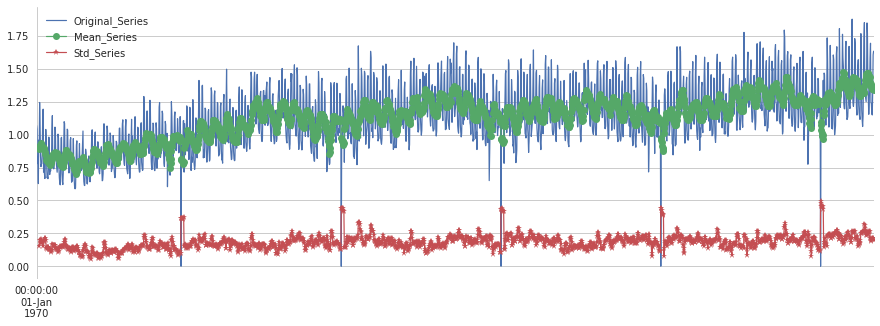


============++++==========

Results of the Dickey_Fuller Test
ADF Statistic: -1.565373
No of lags: 26.000000
No of Obs used for ADF Calculation & Critical Values: 1886.000000
p-value: 0.500960
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568


In [85]:
time_series_stationary_test(train_sales_cal_df[['avg_sales']])

### Biến đổi chuỗi ổn định
Đại đa số trường hợp chúng ta bắt gặp các chuỗi bất ổn định, vì vậy cần phải loại bỏ những yếu tố gây bất ổn định.

In [57]:
# df_log_diff = np.log(train_sales_cal_df[['avg_sales']]) - np.log(train_sales_cal_df[['avg_sales']]).shift()
# #df['sold'] = df_log_diff
# #df['sold'] = df['sold'].dropna()
# df_log_diff = df_log_diff.dropna()

## **Mô hình SARIMAX**
 


## Making Exogeneous Factors

## Validation SARIMAX

## SARIMAX Graphical Validation & Forecasting

## **WRMSSE Calculation**

## **Prophet Time Series Modeling**


## Fb Prophet: Training and Validation Data Split

## Prophet Forecasting On Average Sales Using Seaborn

## Prophet Forecast Using Individual Product IDs

## Custom Loss Function For Fb Prophet Tuning

## WRMSSE Error Calculation on Prediction

# Tổng kết